In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


1.Importing Libraries

In [2]:
# Cell 1: Environment Setup & Library Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For model building, we might use LightGBM (or XGBoost later)
import lightgbm as lgb

# Set global visualization style
sns.set(style="whitegrid")
plt.style.use("seaborn-whitegrid")

# Display all columns in DataFrame outputs
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


/tmp/ipykernel_31/2519214079.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


2.Loading Data

In [3]:
data_path = "../input/store-sales-time-series-forecasting/"

# Load datasets
train_df = pd.read_csv(data_path + "train.csv", parse_dates=['date'])
test_df = pd.read_csv(data_path + "test.csv", parse_dates=['date'])
stores_df = pd.read_csv(data_path + "stores.csv")
oil_df = pd.read_csv(data_path + "oil.csv", parse_dates=['date'])
holidays_df = pd.read_csv(data_path + "holidays_events.csv", parse_dates=['date'])
transactions_df = pd.read_csv(data_path + "transactions.csv", parse_dates=['date'])

# Quick look at the data shapes and a sample of each
print("Train data shape:", train_df.shape)
print(train_df.head())

print("\nTest data shape:", test_df.shape)
print(test_df.head())

print("\nStores data shape:", stores_df.shape)
print(stores_df.head())

print("\nOil data shape:", oil_df.shape)
print(oil_df.head())

print("\nHolidays & Events data shape:", holidays_df.shape)
print(holidays_df.head())

print("\nTransactions data shape:", transactions_df.shape)
print(transactions_df.head())

Train data shape: (3000888, 6)
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

Test data shape: (28512, 5)
        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

Stores data shape: (54, 5)
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichin

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


3.EDA

Missing values in Train DataFrame:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
--------------------------------------------------
Missing values in Test DataFrame:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
--------------------------------------------------
Missing values in Stores DataFrame:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
--------------------------------------------------
Missing values in Oil DataFrame:
date           0
dcoilwtico    43
dtype: int64
--------------------------------------------------
Missing values in Holidays DataFrame:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
--------------------------------------------------
Missing values in Transactions DataFrame:
date            0
store_nbr       0
transactions    0
dtype: int

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


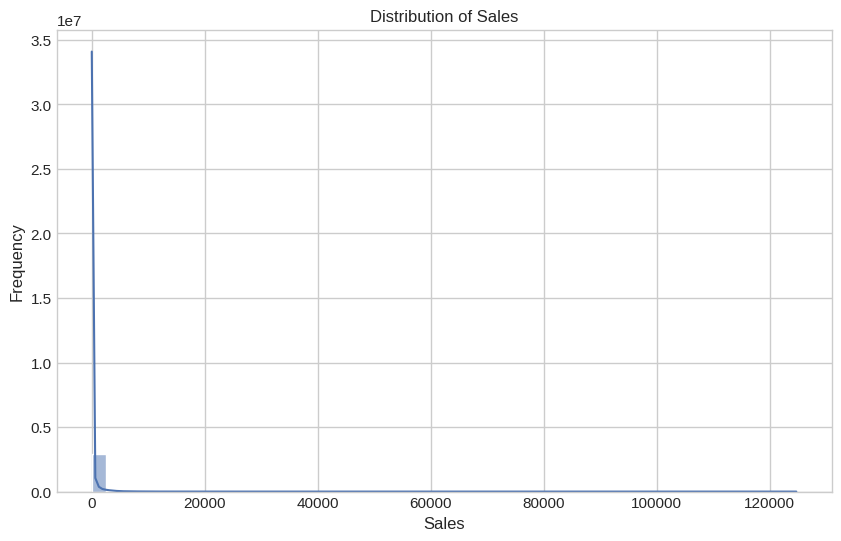

Summary statistics for train data:
                 id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703087872  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662819e+05                            NaN  1.558579e+01   

              sales   onpromotion  
count  3.000888e+06  3.000888e+06  
mean   3.577757e+02  2.602770e+00  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    1.100000e+01  0.000000e+00  
75%    1.958473e+02  0.000000e+00  
max    1.247170e+05  7.410000e+02  
std    1.101998e+03  1.221888e+01  


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


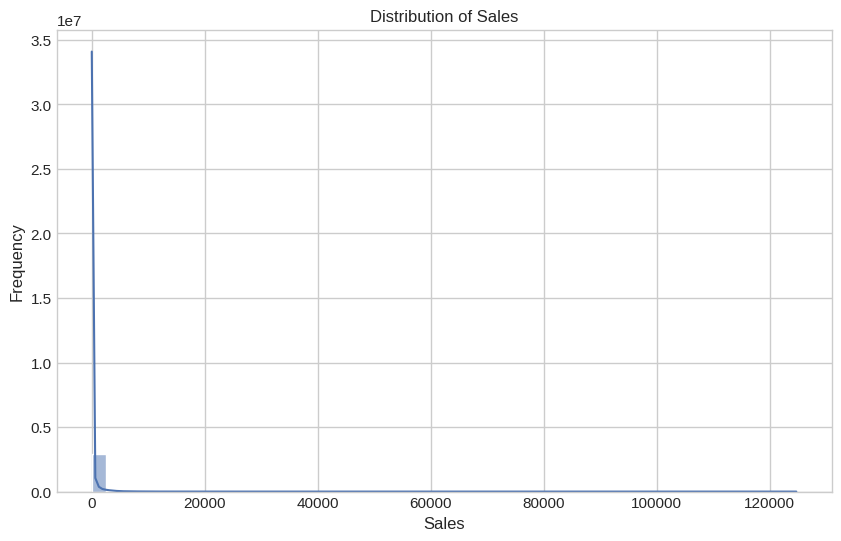

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


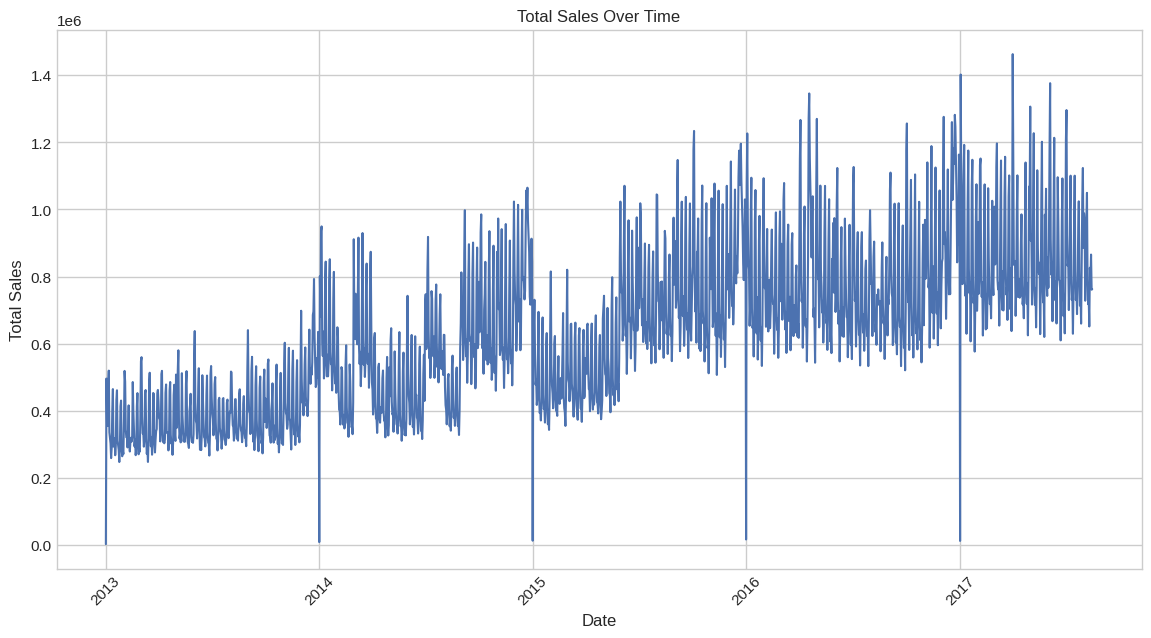

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


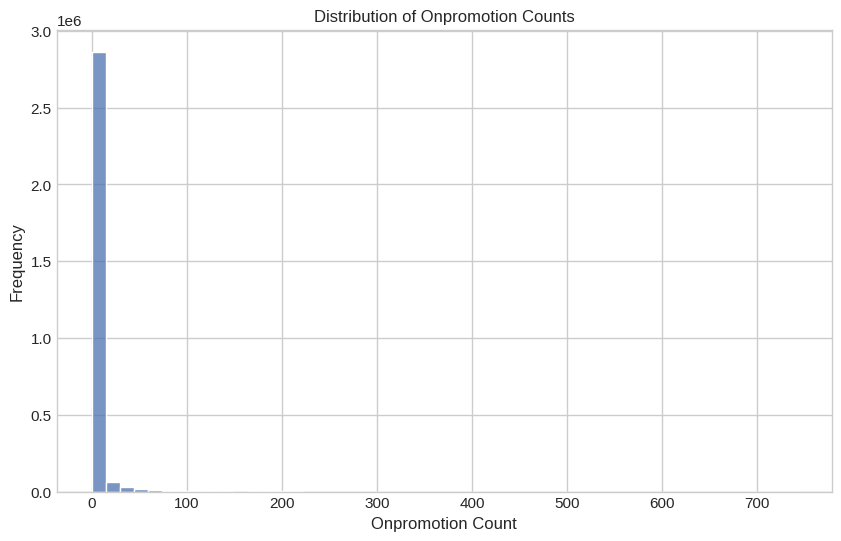

Summary statistics for transactions data:
                                date     store_nbr  transactions
count                          83488  83488.000000  83488.000000
mean   2015-05-20 16:07:40.866232320     26.939237   1694.602158
min              2013-01-01 00:00:00      1.000000      5.000000
25%              2014-03-27 00:00:00     13.000000   1046.000000
50%              2015-06-08 00:00:00     27.000000   1393.000000
75%              2016-07-14 06:00:00     40.000000   2079.000000
max              2017-08-15 00:00:00     54.000000   8359.000000
std                              NaN     15.608204    963.286644


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


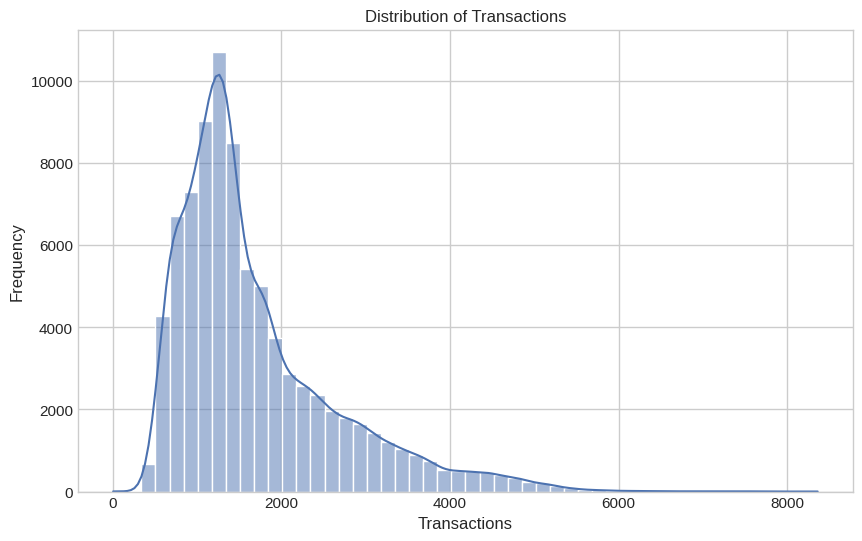

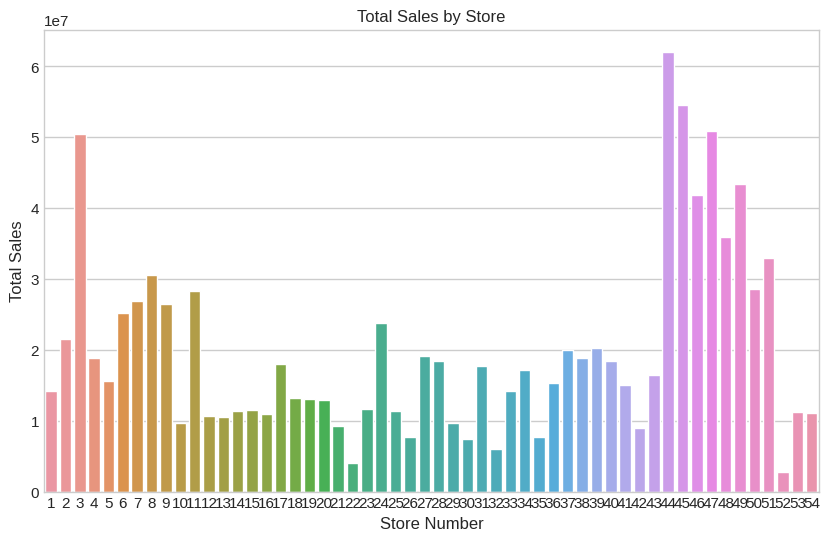

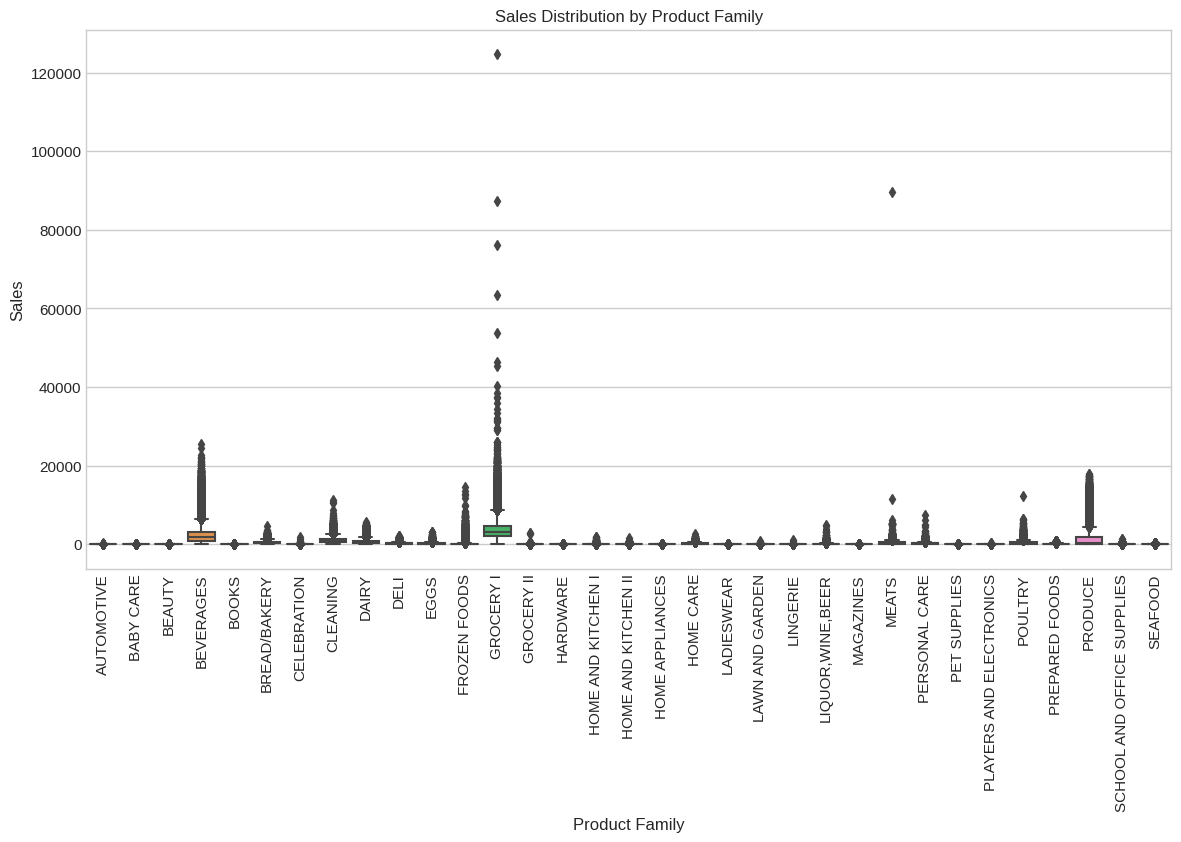

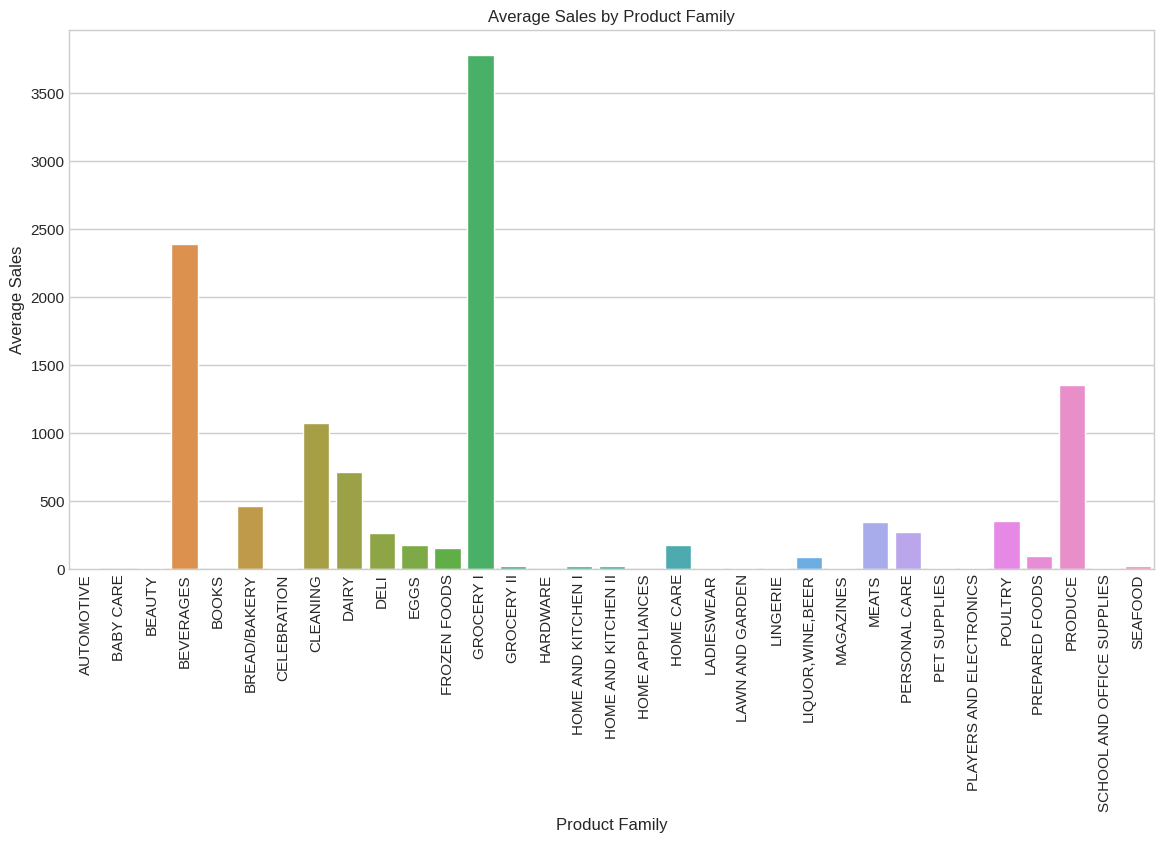

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


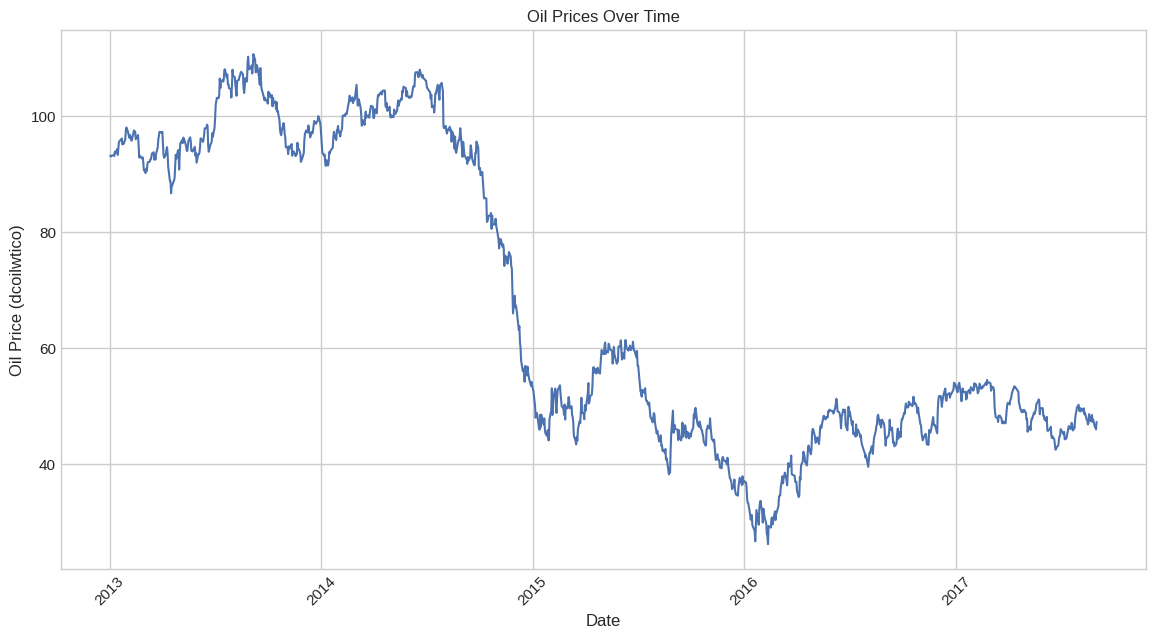

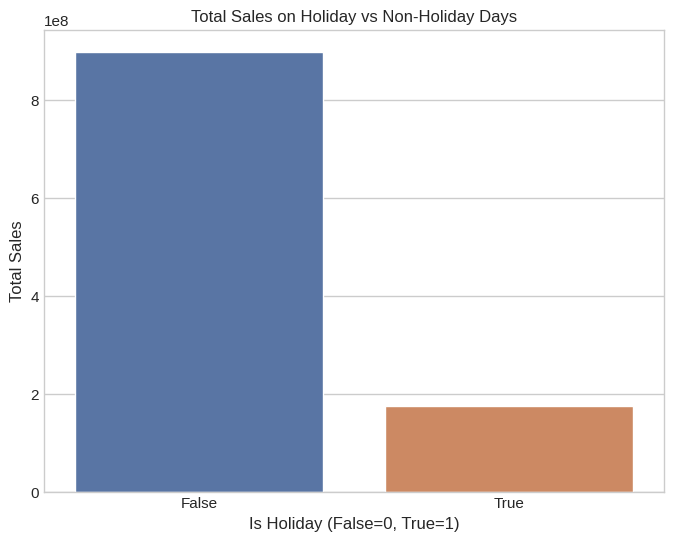

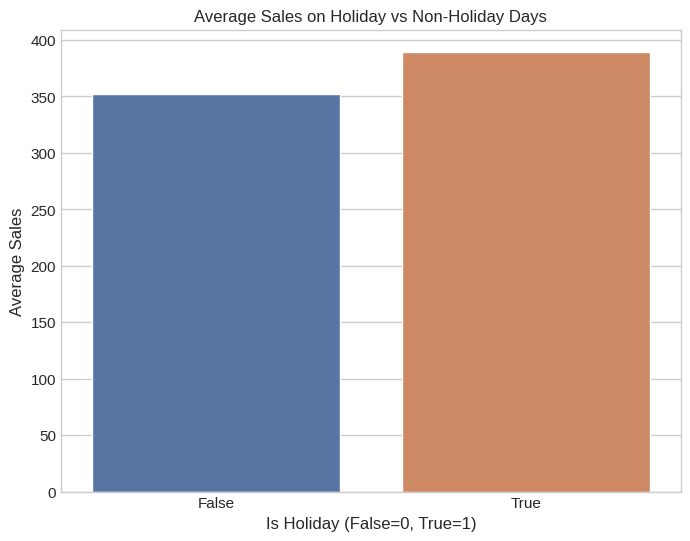

In [4]:
# Check for missing values in each DataFrame
data_frames = {
    'Train': train_df,
    'Test': test_df,
    'Stores': stores_df,
    'Oil': oil_df,
    'Holidays': holidays_df,
    'Transactions': transactions_df
}

for name, df in data_frames.items():
    print(f"Missing values in {name} DataFrame:")
    print(df.isnull().sum())
    print("-" * 50)

# Summary statistics for the training data
print("Summary statistics for train data:")
print(train_df.describe())

# Distribution of sales in the training data
plt.figure(figsize=(10, 6))
sns.histplot(train_df['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

# Summary statistics for the training data
print("Summary statistics for train data:")
print(train_df.describe())

# Distribution of sales in the training data
plt.figure(figsize=(10, 6))
sns.histplot(train_df['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

# Time series trend: Total sales aggregated by date
sales_by_date = train_df.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=sales_by_date, x='date', y='sales')
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

# Analyze the 'onpromotion' feature in the training set
plt.figure(figsize=(10, 6))
sns.histplot(train_df['onpromotion'], bins=50, kde=False)
plt.title("Distribution of Onpromotion Counts")
plt.xlabel("Onpromotion Count")
plt.ylabel("Frequency")
plt.show()

# Transactions data: Summary statistics and distribution
print("Summary statistics for transactions data:")
print(transactions_df.describe())

plt.figure(figsize=(10, 6))
sns.histplot(transactions_df['transactions'], bins=50, kde=True)
plt.title("Distribution of Transactions")
plt.xlabel("Transactions")
plt.ylabel("Frequency")
plt.show()

# Total sales by store (aggregated)
sales_by_store = train_df.groupby('store_nbr')['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_store, x='store_nbr', y='sales')
plt.title("Total Sales by Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.show()

# --- Additional EDA Ideas Implementation ---

# 1. Sales distribution by product family
# Option A: Boxplot to see the spread of sales by family
plt.figure(figsize=(14, 7))
sns.boxplot(data=train_df, x='family', y='sales')
plt.title("Sales Distribution by Product Family")
plt.xlabel("Product Family")
plt.ylabel("Sales")
plt.xticks(rotation=90)
plt.show()

# Option B: Bar plot of average sales per family
family_sales = train_df.groupby('family')['sales'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(data=family_sales, x='family', y='sales')
plt.title("Average Sales by Product Family")
plt.xlabel("Product Family")
plt.ylabel("Average Sales")
plt.xticks(rotation=90)
plt.show()

# 2. Analyze oil prices over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=oil_df, x='date', y='dcoilwtico')
plt.title("Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Oil Price (dcoilwtico)")
plt.xticks(rotation=45)
plt.show()

# 3. Look into holiday effects by merging holidays_df with sales data
# Create an indicator in the training data for whether the date is a holiday
train_df['is_holiday'] = train_df['date'].isin(holidays_df['date'])
holiday_sales = train_df.groupby('is_holiday')['sales'].sum().reset_index()


plt.figure(figsize=(8, 6))
sns.barplot(data=holiday_sales, x='is_holiday', y='sales')
plt.title("Total Sales on Holiday vs Non-Holiday Days")
plt.xlabel("Is Holiday (False=0, True=1)")
plt.ylabel("Total Sales")
plt.show()

# Optional: Compare average sales on holidays vs non-holidays
avg_sales_holiday = train_df.groupby('is_holiday')['sales'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(data=avg_sales_holiday, x='is_holiday', y='sales')
plt.title("Average Sales on Holiday vs Non-Holiday Days")
plt.xlabel("Is Holiday (False=0, True=1)")
plt.ylabel("Average Sales")
plt.show()

4.Feature Engineering

In [5]:
# --- 1. Combine Train and Test Data ---
# Flag training vs. test and create a dummy sales column in test
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['sales'] = np.nan

# Combine train and test for consistent feature engineering
combined_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)
print("Combined data shape:", combined_df.shape)

# --- 2. Date Features ---
combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month
combined_df['day'] = combined_df['date'].dt.day
combined_df['dayofweek'] = combined_df['date'].dt.dayofweek
combined_df['weekofyear'] = combined_df['date'].dt.isocalendar().week.astype(int)
combined_df['quarter'] = combined_df['date'].dt.quarter

# --- 3. Merge External Data ---

# Merge Stores Data
combined_df = combined_df.merge(stores_df, on='store_nbr', how='left')
print("After merging stores, shape:", combined_df.shape)

# Merge Oil Data: Use ffill and bfill to handle missing values
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].ffill().bfill()
combined_df = combined_df.merge(oil_df, on='date', how='left')
print("After merging oil data, shape:", combined_df.shape)

# Merge Transactions Data
combined_df = combined_df.merge(transactions_df, on=['date', 'store_nbr'], how='left')
print("After merging transactions, shape:", combined_df.shape)

# Remove any existing "is_holiday" column before merging holidays to avoid duplicates
if 'is_holiday' in combined_df.columns:
    combined_df.drop(columns=['is_holiday'], inplace=True)

# Merge Holidays Data:
# Ensure the holidays dates are parsed with dayfirst=True (format dd-mm-yyyy)
holidays_df['date'] = pd.to_datetime(holidays_df['date'], dayfirst=True)

# Convert transferred column to boolean if it's not already
if holidays_df['transferred'].dtype == object:
    holidays_df['transferred'] = holidays_df['transferred'].map({'FALSE': False, 'TRUE': True})

# Filter holidays where transferred is False (i.e., holiday is celebrated on that day)
holidays_flag = holidays_df[holidays_df['transferred'] == False][['date']]
holidays_flag = holidays_flag.drop_duplicates()

# Rename the date column to avoid merge conflicts
holidays_flag = holidays_flag.rename(columns={'date': 'holiday_date'})
# Add a holiday flag
holidays_flag['is_holiday_flag'] = 1

# Merge the holiday flag using combined_df.date and holidays_flag.holiday_date
combined_df = combined_df.merge(holidays_flag[['holiday_date', 'is_holiday_flag']],
                                left_on='date', right_on='holiday_date', how='left')
# Fill missing holiday flag values with 0, drop the extra column, and rename the flag column
combined_df['is_holiday'] = combined_df['is_holiday_flag'].fillna(0).astype(int)
combined_df.drop(columns=['holiday_date', 'is_holiday_flag'], inplace=True)
print("After merging holidays, shape:", combined_df.shape)

# --- 4. Lag and Rolling Features ---
# Sort values to ensure correct lag calculations
combined_df.sort_values(by=['store_nbr', 'family', 'date'], inplace=True)

# Create lag features for 'sales' within each store and product family group
combined_df['lag_7'] = combined_df.groupby(['store_nbr', 'family'])['sales'].shift(7)
combined_df['lag_14'] = combined_df.groupby(['store_nbr', 'family'])['sales'].shift(14)

# Create a 7-day rolling average of past sales (shift by 1 day to avoid leakage)
combined_df['rolling_mean_7'] = combined_df.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=7).mean()

# --- 5. Additional Features ---
# Example: Ratio of onpromotion items to transactions (adding 1 to avoid division by zero)
combined_df['promo_ratio'] = combined_df['onpromotion'] / (combined_df['transactions'] + 1)

# Display a sample of the engineered features
print(combined_df.head(10))

Combined data shape: (3029400, 8)
After merging stores, shape: (3029400, 18)
After merging oil data, shape: (3029400, 19)
After merging transactions, shape: (3029400, 20)
After merging holidays, shape: (3029400, 20)
          id       date  store_nbr      family  sales  onpromotion  is_train  \
0          0 2013-01-01          1  AUTOMOTIVE    0.0            0         1   
1782    1782 2013-01-02          1  AUTOMOTIVE    2.0            0         1   
3564    3564 2013-01-03          1  AUTOMOTIVE    3.0            0         1   
5346    5346 2013-01-04          1  AUTOMOTIVE    3.0            0         1   
7128    7128 2013-01-05          1  AUTOMOTIVE    5.0            0         1   
8910    8910 2013-01-06          1  AUTOMOTIVE    2.0            0         1   
10692  10692 2013-01-07          1  AUTOMOTIVE    0.0            0         1   
12474  12474 2013-01-08          1  AUTOMOTIVE    2.0            0         1   
14256  14256 2013-01-09          1  AUTOMOTIVE    2.0           

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


5.Data Preprocessing

In [7]:
# ----- Handle Missing Values -----
# Fill missing transactions and oil prices if any remain
combined_df['transactions'] = combined_df['transactions'].ffill().bfill()
combined_df['dcoilwtico'] = combined_df['dcoilwtico'].ffill().bfill()

# ----- Separate Train and Test Data -----
# Training data: where is_train==1 and we have a valid sales value
train_data = combined_df[combined_df['is_train'] == 1].copy()
# Test data: where is_train==0 (sales remains NaN)
test_data = combined_df[combined_df['is_train'] == 0].copy()

# ----- Drop Rows with Missing Lag Features in Training Data -----
# (These typically correspond to the first few days with no available lag data)
train_data = train_data.dropna(subset=['lag_7', 'lag_14', 'rolling_mean_7'])
print("Training data after dropping rows with missing lag features:", train_data.shape)

# ----- Convert Relevant Columns to Categorical -----
# For modeling (e.g., with LightGBM), it's useful to mark categorical features
cat_cols = ['store_nbr', 'family', 'city', 'state', 'type']
for col in cat_cols:
    train_data[col] = train_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

# ----- Create Time-Based Train/Validation Split -----
# Sort training data by date to maintain time series order
train_data.sort_values('date', inplace=True)

# Define a validation start date (e.g., last 90 days of training data)
val_start_date = train_data['date'].max() - pd.Timedelta(days=90)

# Split into train and validation sets based on date
train_set = train_data[train_data['date'] < val_start_date].copy()
val_set   = train_data[train_data['date'] >= val_start_date].copy()


print("Final Training Set Shape:", train_set.shape)
print("Validation Set Shape:", val_set.shape)
print("Test Set Shape:", test_data.shape)

# ----- Prepare Feature and Target Lists -----
# Define the list of features to use (dropping columns not needed for modeling)
# We'll drop identifiers, date, target (sales), and the is_train flag.
features = ['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day', 
            'dayofweek', 'weekofyear', 'quarter', 'city', 'state', 'type', 
            'cluster', 'dcoilwtico', 'transactions', 'is_holiday', 
            'lag_7', 'lag_14', 'rolling_mean_7', 'promo_ratio']

# The target variable
target = 'sales'

# Optionally, inspect the features
print("Feature list for modeling:", features)


Training data after dropping rows with missing lag features: (2975940, 24)
Final Training Set Shape: (2813778, 24)
Validation Set Shape: (162162, 24)
Test Set Shape: (28512, 24)
Feature list for modeling: ['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day', 'dayofweek', 'weekofyear', 'quarter', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'transactions', 'is_holiday', 'lag_7', 'lag_14', 'rolling_mean_7', 'promo_ratio']


6.Model Training and Evaluation

In [8]:
import lightgbm as lgb
import numpy as np

# Define the RMSLE function (for external evaluation if needed)
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)  # Ensure predictions are non-negative
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

# Define a custom evaluation metric for LightGBM
def lgb_rmsle(preds, dataset):
    labels = dataset.get_label()
    preds = np.maximum(0, preds)  # Ensure non-negative predictions
    score = np.sqrt(np.mean((np.log1p(preds) - np.log1p(labels)) ** 2))
    return 'rmsle', score, False  # False indicates that lower is better

# Prepare LightGBM datasets using our feature list and target variable
lgb_train = lgb.Dataset(train_set[features], label=train_set[target], categorical_feature=cat_cols)
lgb_val = lgb.Dataset(val_set[features], label=val_set[target], categorical_feature=cat_cols, reference=lgb_train)

# Set LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'None',  # We'll use our custom evaluation metric
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42,
}

# Create a dictionary to record evaluation results using the callback
evals_result = {}

# Train the model with early stopping using callbacks
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    feval=lgb_rmsle,
    callbacks=[lgb.record_evaluation(evals_result), lgb.early_stopping(100)]
)

print("Best iteration:", model.best_iteration)
print("Validation RMSLE:", model.best_score['valid']['rmsle'])

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[950]	train's rmsle: 0.798186	valid's rmsle: 0.574787
Best iteration: 950
Validation RMSLE: 0.5747873497636363


7.Predictions and Submission

In [10]:
# Generate predictions on the test set using the best iteration of the model
predictions = model.predict(test_data[features], num_iteration=model.best_iteration)

# Ensure predictions are non-negative (clip negative values to zero)
predictions = np.maximum(0, predictions)

# Create the submission DataFrame with the required 'id' and 'sales' columns
submission = test_data[['id']].copy()
submission['sales'] = predictions

# Display the first few rows of the submission DataFrame
print(submission.head())

# Save the submission file to CSV
submission.to_csv('submission.csv', index=False)

              id     sales
3000888  3000888  0.000000
3002670  3002670  3.788759
3004452  3004452  4.212985
3006234  3006234  4.412581
3008016  3008016  4.194674
